In [1]:
#default_exp pv_forecast

# Charging with PV Forecast

Previously, we tried to produce a charge profile by constructing optimal charge profiles for each day, and then using these optimal charge profiles as targets in our models.

Here we will try and predict the optimal charge profile by first forecasting PV, then constructing an optimal profile based on the forecast. The hope is that estimating solar PV is easier than estimating optimal charge profiles, which tend to be pretty spiky and have given us weird residuals. 

### Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from moepy.lowess import quantile_model

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GroupKFold


# from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from batopt import clean, discharge, utils, charge

import FEAutils as hlp

### User inputs

In [3]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'
charge_opt_model_fp = '../models/charge_opt.sav'

### Preparing data

In [4]:
#exports
def prepare_training_input_data(intermediate_data_dir, start_hour=5):
    # Loading input data
    df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
    df_features = charge.construct_df_charge_features(df)
    
    # Filtering for overlapping feature and target data
    dt_idx = pd.date_range(df_features.index.min(), df['pv_power_mw'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')

    s_pv = df.loc[dt_idx, 'pv_power_mw']
    df_features = df_features.loc[dt_idx]
        
    # Filtering for evening datetimes
    charging_datetimes = charge.extract_charging_datetimes(df_features, start_hour=start_hour)
    
    X = df_features.loc[charging_datetimes]
    y = s_pv.loc[charging_datetimes]
    
    return X, y

### Fitting forecast model

We will quickly fit a PV model just to check the residuals and that the data is all fine:

In [5]:
X, y = prepare_training_input_data(intermediate_data_dir)

In [6]:
df_pred = clean.generate_kfold_preds(X.values, y.values, RandomForestRegressor(), index=X.index)

Analysing residuals

Text(0, 0.5, 'Prediction')

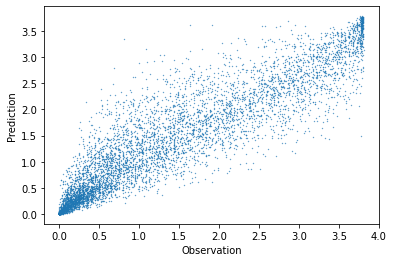

In [7]:
plt.scatter(df_pred.true, df_pred.pred, s=0.1)
plt.xlabel('Observation')
plt.ylabel('Prediction')

### Analysing random days

In [8]:
#exports
def plot_random_day(df_pred, ax=None):
    """
    View predicted and observed PV profiles
    """
    if ax is None:
        ax = plt.gca()
    
    random_day = pd.to_datetime(np.random.choice(df_pred.index.date))
    random_day = df_pred[df_pred.index.date==random_day]
    plt.plot(random_day.true)
    plt.plot(random_day.pred)
    
    return ax

<AxesSubplot:>

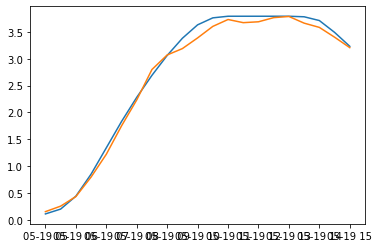

In [9]:
plot_random_day(df_pred)

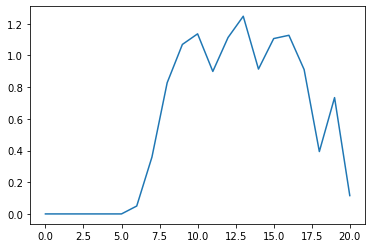

In [10]:
random_solar_profile = discharge.sample_random_day(df_pred.pred).pipe(charge.extract_solar_profile)
adj_random_solar_profile = discharge.flatten_peak(random_solar_profile)
charge_profile = charge.construct_charge_profile(random_solar_profile, adj_random_solar_profile)
plt.plot(charge_profile)

### Predicting charge based on PV forecast

Now we will begin developing a unified approach for predicting PV and then optimising the battery charge schedule. 

We will also group by week. This should make the problem a bit harder, and help encourage the final model to generalise to lengthy unseen periods.

In [11]:
#exports
def generate_kfold_preds_weeks(X, y, model, groups, kfold_kwargs, index=None):
    """
    Generate kfold preds, grouping by week
    """
    
    group_kfold = GroupKFold(**kfold_kwargs)
    
    df_pred = pd.DataFrame(columns=['pred', 'true'], index=np.arange(X.shape[0]))

    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        df_pred.loc[test_index, 'true'] = y_test
        df_pred.loc[test_index, 'pred'] = model.predict(X_test)

    df_pred.sort_index()

    if index is not None:
        assert len(index) == df_pred.shape[0], 'The passed index must be the same length as X and y'
        df_pred.index = index

    return df_pred
    

In [12]:
#exports
def generate_kfold_charge_preds(X, y, model, groups, kfold_kwargs={'n_splits': 5}):
    """
    Fit the PV forecasting model and calculate the optimal charge profile for predictions.
    """
    df_pred = generate_kfold_preds_weeks(X.values, y.values, model, groups, kfold_kwargs=kfold_kwargs, index=X.index)
    charge_pred = charge.construct_charge_s(df_pred.pred)
    charge_pred = charge.post_pred_charge_proc_func(charge_pred)
    return pd.DataFrame({'charge_pred': charge_pred, 
                         'pv_actual': df_pred.true,
                         'pv_pred': df_pred.pred})


In [13]:
#exports
def predict_charge(X, model):
    """
    Given a fitted PV forecast model and feature array X, get the optimal charge profile. 
    """
    pv_pred = pd.Series(model.predict(X), index=X.index)
    charge_pred = charge.construct_charge_s(pv_pred)
    charge_pred = charge.post_pred_charge_proc_func(charge_pred)
    return pd.Series(charge_pred, index=X.index)

### Holding out final month

In [14]:
def get_train_test(arr, start_of_test_period): 
    train_arr = arr[:pd.to_datetime(start_of_test_period, utc=True)]
    test_arr = arr[pd.to_datetime(start_of_test_period, utc=True):]
    
    return train_arr, test_arr

start_of_test_period = '2018-09-15'

X_train, X_test = get_train_test(X, start_of_test_period)
y_train, y_test = get_train_test(y, start_of_test_period)

### Fitting some models

Now let's try executing this unified approach using k-fold CV, for 3 default models on the training data:

In [179]:
models = {
    'std_linear': LinearRegression(),
    'lasso': Lasso(),
    'ridge': Ridge(),
    'boosted': GradientBoostingRegressor(),
    'random_forest': RandomForestRegressor(),
}

# Define the week groups
week_groups = X_train.index.year + X_train.index.isocalendar().week/52

for key in models:
    charge_pred_df = generate_kfold_charge_preds(X_train, y_train, models[key], week_groups)
    score = charge.score_charging(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
    pv_mse = np.mean(np.square(charge_pred_df.pv_actual - charge_pred_df.pv_pred))
    solar_exploit_pct = 100*charge.prop_max_solar(charge_pred_df.charge_pred, charge_pred_df.pv_actual)
    print("{}: PV MSE: {:.2f}, score: {:.2f}, solar exploit: {:.2f}%".format(key, pv_mse, score, solar_exploit_pct))

std_linear: PV MSE: 0.38, score: 0.83, solar exploit: 95.56%
lasso: PV MSE: 0.42, score: 0.82, solar exploit: 94.72%
ridge: PV MSE: 0.38, score: 0.83, solar exploit: 95.56%
boosted: PV MSE: 0.39, score: 0.83, solar exploit: 95.40%
random_forest: PV MSE: 0.39, score: 0.83, solar exploit: 95.45%


Interestingly, there is little difference between the models in terms of solar exploit, even though there are large differences in the MSE of the PV forecasts. For our previous attempt at the charging task, the linear model was much worse than the boosted model and RF in terms of solar exploit. This suggests that a weak (or under-fitted) estimator of solar PV actually performs quite well when it comes to 

In [17]:
best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)
preds = predict_charge(X_test, best_model)

In [18]:
100*charge.prop_max_solar(preds, y_test)

93.06662002508108

In [30]:
def construct_solar_exploit_calculator(solar_profile, charging_datetimes=None, scorer=False):
    if charging_datetimes is None:
        charging_datetimes = charge.extract_charging_datetimes(solar_profile)
            
    def calc_solar_exploitation(y, y_pred):
        # Checking evening datetimes
        if hasattr(y_pred, 'index') == True:
            charging_datetimes = charge.extract_charging_datetimes(y_pred)
            
        assert y_pred.shape[0] == solar_profile.loc[charging_datetimes].shape[0], f'The prediction series must be the same length as the number of charging datetimes in the main dataframe, {y_pred.shape[0]} {s_demand.loc[evening_datetimes].shape[0]}'
        
        charge_pred = charge.construct_charge_s(y_pred)
        charge_pred = charge.post_pred_charge_proc_func(charge_pred)
        
        exploitation_pct = 100 * charge.prop_max_solar(charge_pred, solar_profile.loc[charging_datetimes])

        return exploitation_pct

    if scorer == True:
        return make_scorer(calc_solar_exploitation)
    else:
        return calc_solar_exploitation

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   57.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   57.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s finished


validation score: 95.20527127538253
test score: 93.13712585064854
best params: OrderedDict([('pandas_RF__bootstrap', True), ('pandas_RF__criterion', 'mse'), ('pandas_RF__max_depth', 196), ('pandas_RF__max_features', 'auto'), ('pandas_RF__min_samples_leaf', 1), ('pandas_RF__min_samples_split', 8), ('pandas_RF__n_estimators', 136)])


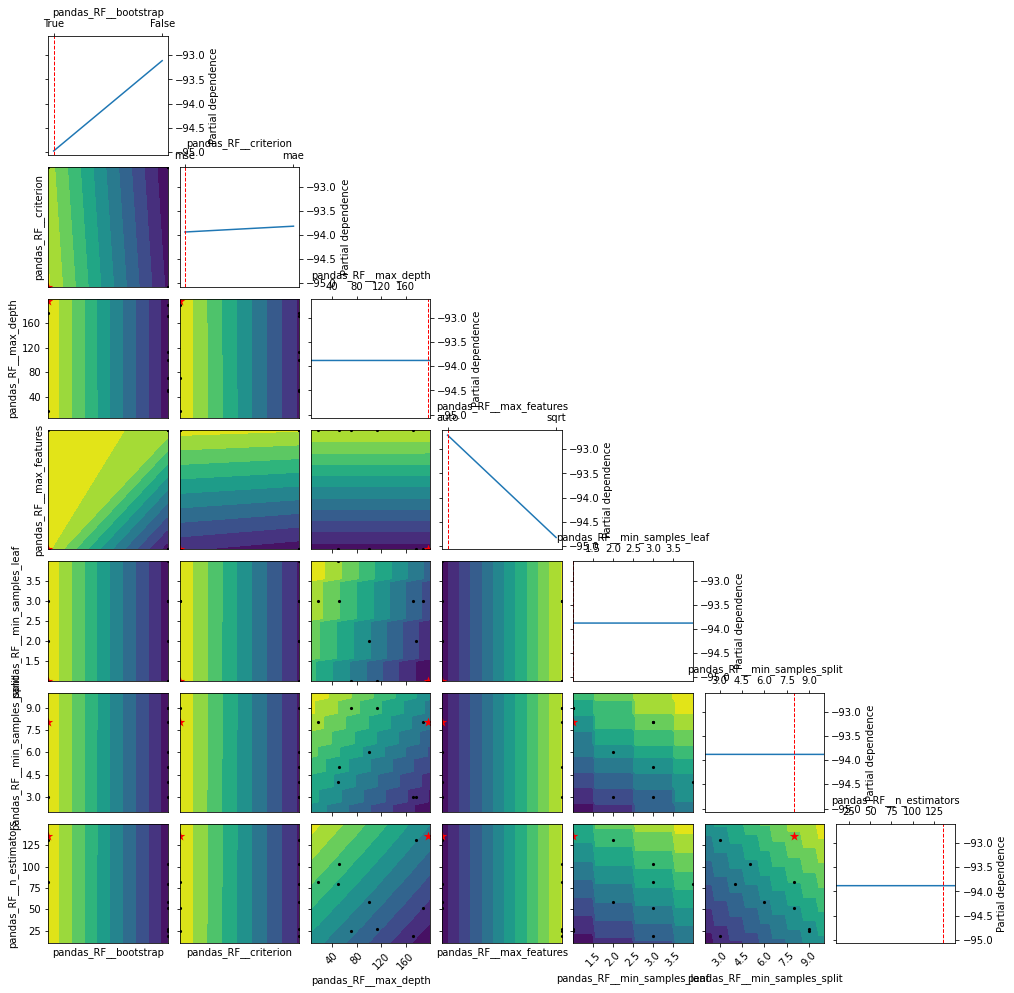

In [74]:
X, y = prepare_training_input_data(intermediate_data_dir)

start_of_test_period = '2018-09-15'

X_train, X_test = get_train_test(X, start_of_test_period)
y_train, y_test = get_train_test(y, start_of_test_period)

charging_datetimes = charge.extract_charging_datetimes(X_train)
solar_exploit_scorer = construct_solar_exploit_calculator(solar_profile=y, 
                                                            charging_datetimes=charging_datetimes, 
                                                            scorer=True)
groups = charging_datetimes.date

pipeline = Pipeline([
    ('pandas_RF', utils.PandasRandomForestRegressor())
])

search_spaces = {
        'pandas_RF__min_samples_leaf': Integer(1, 20, 'uniform'),
        'pandas_RF__criterion': Categorical(['mse', 'mae']),
        'pandas_RF__n_estimators': Integer(10, 150, 'uniform'),
        'pandas_RF__max_features': Categorical(['auto', 'sqrt']),
        'pandas_RF__max_depth': Integer(5, 200, 'uniform'),
        'pandas_RF__min_samples_split': Integer(2, 10, 'uniform'),
        'pandas_RF__min_samples_leaf': Integer(1, 4, 'uniform'),
        'pandas_RF__bootstrap': Categorical([True, False])
}

opt = utils.BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=10,
    verbose=1,
    cv=4, 
    scoring=solar_exploit_scorer,
    n_jobs=-1
)

fit_BayesSearchCV = True

if fit_BayesSearchCV == True:
    opt.fit(X_train, y_train, groups=groups)

    print(f'validation score: {opt.best_score_}')
    print(f'held out score: {opt.score(X_test, y_test)}')
    print(f'best params: {opt.best_params_}')

    _ = plot_objective(opt.optimizer_results_[0])
    plt.show()

<br>

Finally we'll export the relevant code to our `batopt` module

In [ ]:
#hide
from nbdev.export import notebook2script
    
notebook2script()